# Installation

In [1]:
# Install required packages.
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


     |████████████████████████████████| 7.9 MB 2.7 MB/s 
     |████████████████████████████████| 3.5 MB 2.6 MB/s 
     |████████████████████████████████| 407 kB 5.0 MB/s 
     |████████████████████████████████| 45 kB 2.5 MB/s 


# Helper Fns

In [2]:
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [5]:

def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


# Data

In [3]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...



Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Done!


In [4]:
import networkx as nx


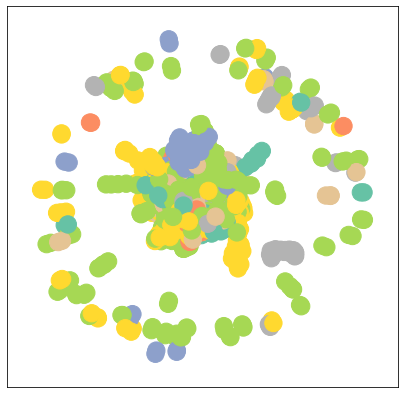

In [6]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

In [7]:
to_networkx??

In [10]:
data.subgraph

<bound method Data.subgraph of Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])>

# Model Part

In [13]:
dataset.num_features

1433

In [19]:
import torch
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):

  def __init__(self, hidden_channels):
    super().__init__()
    torch.manual_seed(12)
    self.conv1=GCNConv(dataset.num_features, hidden_channels)
    self.conv2=GCNConv(hidden_channels, hidden_channels)
    self.conv3=GCNConv(hidden_channels, hidden_channels//2)
    self.conv4=GCNConv(hidden_channels//2, dataset.num_classes)
  
  def forward(self, x, edge_index):
    x= self.conv1(x, edge_index)
    x=x.relu()
    x=self.conv2(x, edge_index)
    x=x.relu()
    x=self.conv3(x, edge_index)
    x=x.relu()
    x=self.conv4(x, edge_index)
    return x

model= GCN(hidden_channels= 64)
print(model)
                  


GCN(
  (conv1): GCNConv(1433, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 32)
  (conv4): GCNConv(32, 7)
)


> Node embeddings of untrained model

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


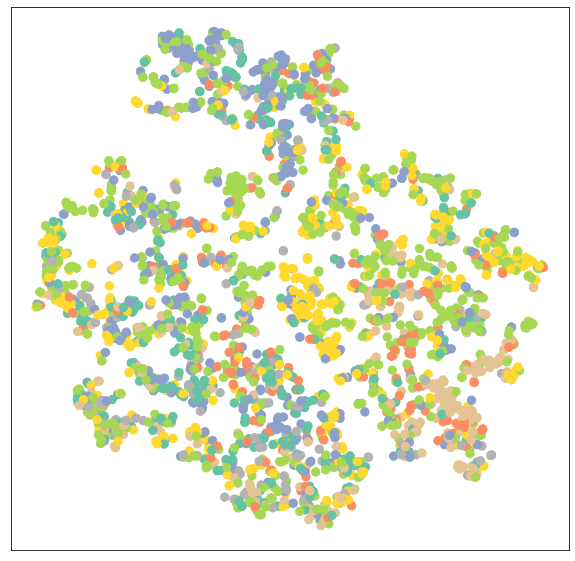

In [20]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

> Training

In [25]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 100):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9457
Epoch: 002, Loss: 1.9425
Epoch: 003, Loss: 1.9371
Epoch: 004, Loss: 1.9288
Epoch: 005, Loss: 1.9158
Epoch: 006, Loss: 1.8969
Epoch: 007, Loss: 1.8701
Epoch: 008, Loss: 1.8329
Epoch: 009, Loss: 1.7843
Epoch: 010, Loss: 1.7242
Epoch: 011, Loss: 1.6517
Epoch: 012, Loss: 1.5667
Epoch: 013, Loss: 1.4708
Epoch: 014, Loss: 1.3654
Epoch: 015, Loss: 1.2504
Epoch: 016, Loss: 1.1282
Epoch: 017, Loss: 1.0005
Epoch: 018, Loss: 0.8711
Epoch: 019, Loss: 0.7477
Epoch: 020, Loss: 0.6302
Epoch: 021, Loss: 0.5198
Epoch: 022, Loss: 0.4237
Epoch: 023, Loss: 0.3406
Epoch: 024, Loss: 0.2688
Epoch: 025, Loss: 0.2120
Epoch: 026, Loss: 0.1670
Epoch: 027, Loss: 0.1315
Epoch: 028, Loss: 0.1034
Epoch: 029, Loss: 0.0828
Epoch: 030, Loss: 0.0662
Epoch: 031, Loss: 0.0532
Epoch: 032, Loss: 0.0436
Epoch: 033, Loss: 0.0362
Epoch: 034, Loss: 0.0304
Epoch: 035, Loss: 0.0263
Epoch: 036, Loss: 0.0231
Epoch: 037, Loss: 0.0205
Epoch: 038, Loss: 0.0182
Epoch: 039, Loss: 0.0169
Epoch: 040, Loss: 0.0157


In [26]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7730


# Now lets add some drop out

In [29]:
import torch.nn.functional as F
class GCN_drop(torch.nn.Module):

  def __init__(self, hidden_channels):
    super().__init__()
    torch.manual_seed(12)
    self.conv1=GCNConv(dataset.num_features, hidden_channels)
    self.conv2=GCNConv(hidden_channels, hidden_channels)
    self.conv3=GCNConv(hidden_channels, hidden_channels//2)
    self.conv4=GCNConv(hidden_channels//2, dataset.num_classes)
  
  def forward(self, x, edge_index):
    x= self.conv1(x, edge_index)
    x=x.relu()
    x = F.dropout(x, p=0.6, training=self.training)
    x=self.conv2(x, edge_index)
    x=x.relu()
    x = F.dropout(x, p=0.6, training=self.training)
    x=self.conv3(x, edge_index)
    x=x.relu()
    x = F.dropout(x, p=0.6, training=self.training)
    x=self.conv4(x, edge_index)
    return x

model2= GCN_drop(hidden_channels= 64)
print(model2)

GCN_drop(
  (conv1): GCNConv(1433, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 32)
  (conv4): GCNConv(32, 7)
)


In [30]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model2 = GCN_drop(hidden_channels=64)
optimizer = torch.optim.Adam(model2.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model2.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model2(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model2.eval()
      out = model2(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9457
Epoch: 002, Loss: 1.9435
Epoch: 003, Loss: 1.9424
Epoch: 004, Loss: 1.9381
Epoch: 005, Loss: 1.9298
Epoch: 006, Loss: 1.9163
Epoch: 007, Loss: 1.9029
Epoch: 008, Loss: 1.8963
Epoch: 009, Loss: 1.8696
Epoch: 010, Loss: 1.8435
Epoch: 011, Loss: 1.8265
Epoch: 012, Loss: 1.7842
Epoch: 013, Loss: 1.7213
Epoch: 014, Loss: 1.6067
Epoch: 015, Loss: 1.5530
Epoch: 016, Loss: 1.4950
Epoch: 017, Loss: 1.4627
Epoch: 018, Loss: 1.3055
Epoch: 019, Loss: 1.2129
Epoch: 020, Loss: 1.1572
Epoch: 021, Loss: 1.0413
Epoch: 022, Loss: 0.9842
Epoch: 023, Loss: 0.9219
Epoch: 024, Loss: 0.8242
Epoch: 025, Loss: 0.7565
Epoch: 026, Loss: 0.7168
Epoch: 027, Loss: 0.6312
Epoch: 028, Loss: 0.6726
Epoch: 029, Loss: 0.5594
Epoch: 030, Loss: 0.4947
Epoch: 031, Loss: 0.5147
Epoch: 032, Loss: 0.4505
Epoch: 033, Loss: 0.4337
Epoch: 034, Loss: 0.4609
Epoch: 035, Loss: 0.3696
Epoch: 036, Loss: 0.3483
Epoch: 037, Loss: 0.2892
Epoch: 038, Loss: 0.3086
Epoch: 039, Loss: 0.2610
Epoch: 040, Loss: 0.2324


In [31]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7410


> Visualizing the embeddings from first model

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


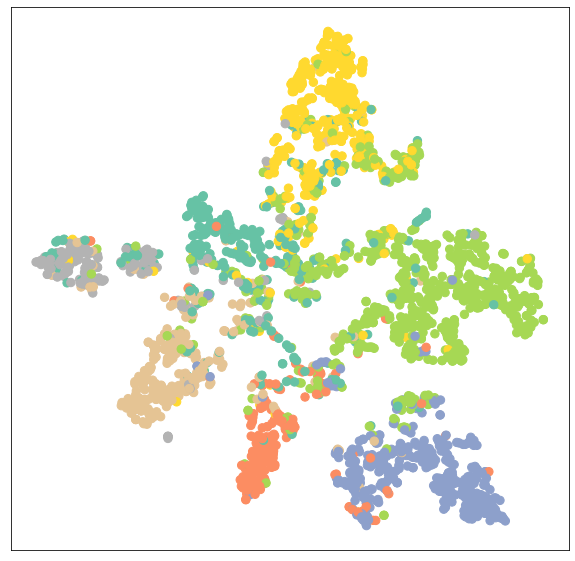

In [32]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

> Visualizing the embeddings from model2

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


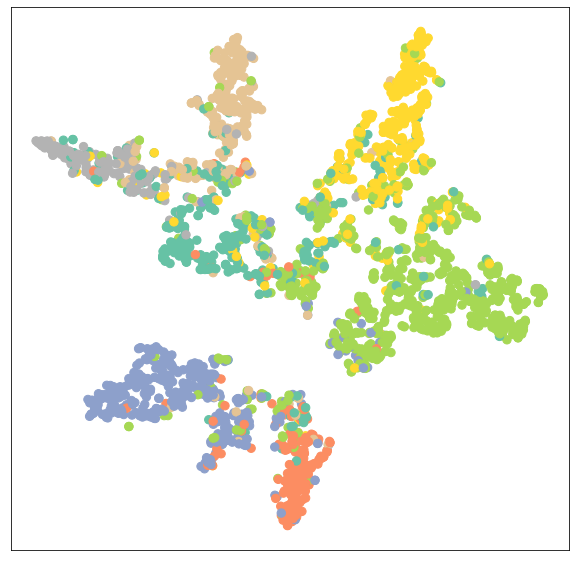

In [33]:
model2.eval()

out = model2(data.x, data.edge_index)
visualize(out, color=data.y)